In [0]:
#!pip install tf-nightly

In [0]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
!pip install tensorflow==1.15

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np 

Using TensorFlow backend.


In [0]:
from tensorflow import keras # version 2.2.4-tf
import numpy as np
from keras.preprocessing.sequence import TimeseriesGenerator
print(keras.__version__)

2.2.4-tf


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, CuDNNLSTM, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

In [0]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [0]:
!ls

drive  sample_data  spark-2.4.5-bin-hadoop2.7  spark-2.4.5-bin-hadoop2.7.tgz


In [0]:
# from google.colab import files
# files.upload()

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
print(spark)
filelocation1 = "/content/drive/My Drive/data/train.csv"
filelocation3 = "/content/drive/My Drive/data/stores.csv"
filelocation4 = "/content/drive/My Drive/data/features.csv"

In [0]:
df1 = (spark.read.option('header','true').option("inferSchema", "true").csv(filelocation1))
df3 = (spark.read.option('header','true').option('delimiter',",").option("inferSchema", "true").csv(filelocation3))
df4 = (spark.read.option('header','true').option('delimiter',",").option("inferSchema", "true").csv(filelocation4))

In [0]:
df = df1.join(df3,on=["Store"],how='inner')

In [0]:
df_final= df.join(df4,on=["Store","Date","IsHoliday"],how="inner")

In [0]:
df_pandas=df1.toPandas()

In [0]:
df_pandas['Date'] = pd.to_datetime(df_pandas['Date'])
print("The dataset has {} number of days data".format(((df_pandas['Date'].max()-df_pandas['Date'].min())/np.timedelta64(1,'D'))))
print("which is equal to {} months of data".format((df_pandas['Date'].max()-df_pandas['Date'].min())/np.timedelta64(1,'M')))
print("equal to {} years of data".format((df_pandas['Date'].max()-df_pandas['Date'].min())/np.timedelta64(1,'Y')))
print("2010 has {} rows of data".format(len(df_pandas[df_pandas['Date'].dt.year==2010])))
print("2011 has {} rows of data".format(len(df_pandas[df_pandas['Date'].dt.year==2011])))
print("2012 has {} rows of data".format(len(df_pandas[df_pandas['Date'].dt.year==2012])))

The dataset has 994.0 number of days data
which is equal to 32.65775477935892 months of data
equal to 2.7214795649465766 years of data
2010 has 140679 rows of data
2011 has 153453 rows of data
2012 has 127438 rows of data


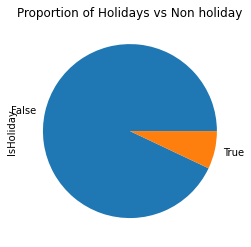

In [0]:
df_pandas.groupby('IsHoliday').IsHoliday.count().plot(kind='pie',title='Proportion of Holidays vs Non holiday')

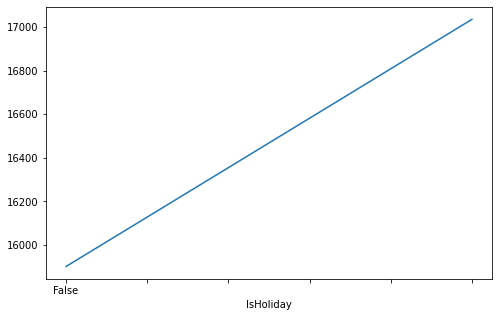

In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
#df_pandas.groupby(['Store','IsHoliday','Date']).Weekly_Sales.mean().plot()
df_pandas.groupby(['IsHoliday']).Weekly_Sales.mean().plot()

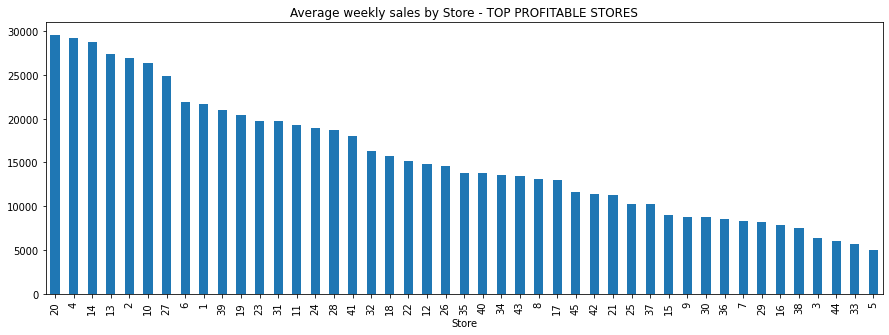

In [0]:
%matplotlib inline
fig_dims = (15, 5)
fig, ax = plt.subplots(figsize= fig_dims)
df_pandas.groupby('Store').Weekly_Sales.mean().sort_values(ascending=False).plot(kind='bar',title='Average weekly sales by Store - TOP PROFITABLE STORES' )

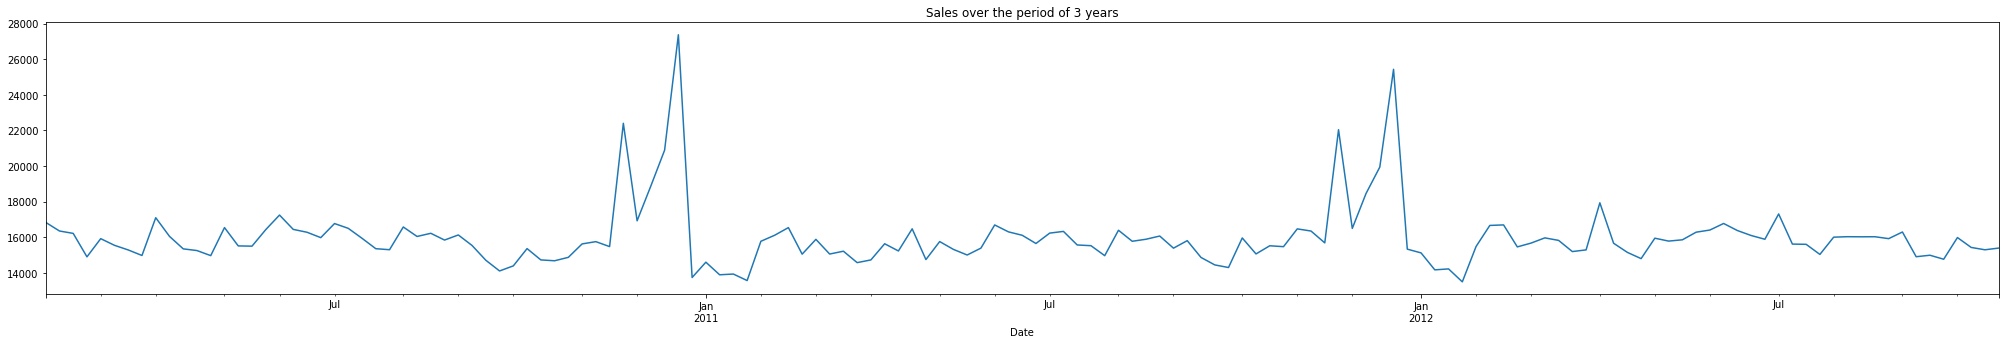

In [0]:
%matplotlib inline
fig_dims = (35, 5)
fig, ax = plt.subplots(figsize= fig_dims)
df_pandas.groupby('Date').Weekly_Sales.mean().plot(kind='line',title='Sales over the period of 3 years')

In [0]:
df_pandas_1 = df_pandas.set_index(['Date'])

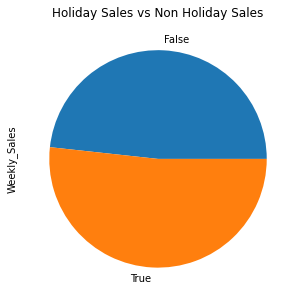

In [0]:
%matplotlib inline
fig_dims = (10, 5)
fig, ax = plt.subplots(figsize= fig_dims)
df_pandas_1.groupby('IsHoliday').Weekly_Sales.mean().plot(kind='pie',title='Holiday Sales vs Non Holiday Sales')

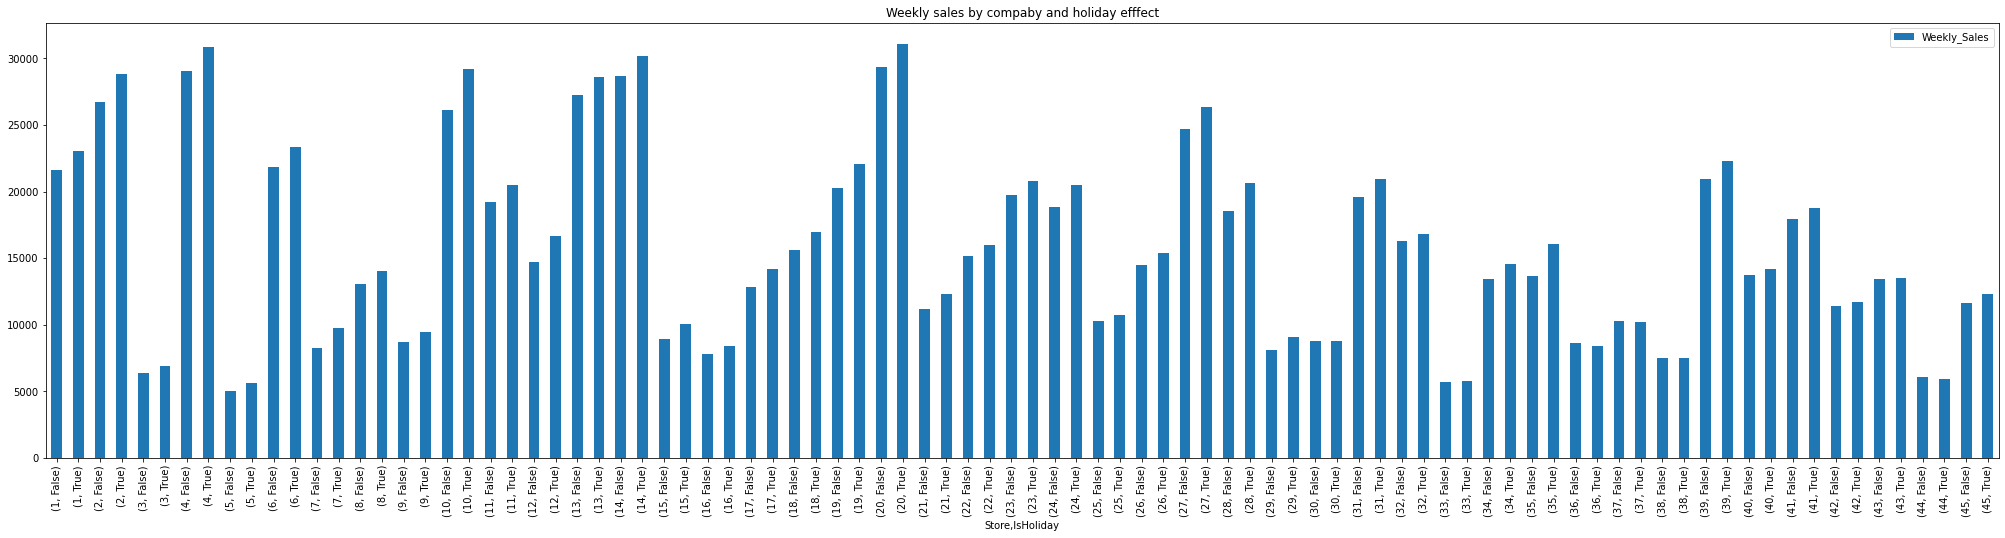

In [0]:
%matplotlib inline
fig_dims = (35, 8)
fig, ax = plt.subplots(figsize= fig_dims)
df_pandas_1.groupby(['Store','IsHoliday']).Weekly_Sales.mean().plot(kind='bar', legend=True,title='Weekly sales by compaby and holiday efffect')

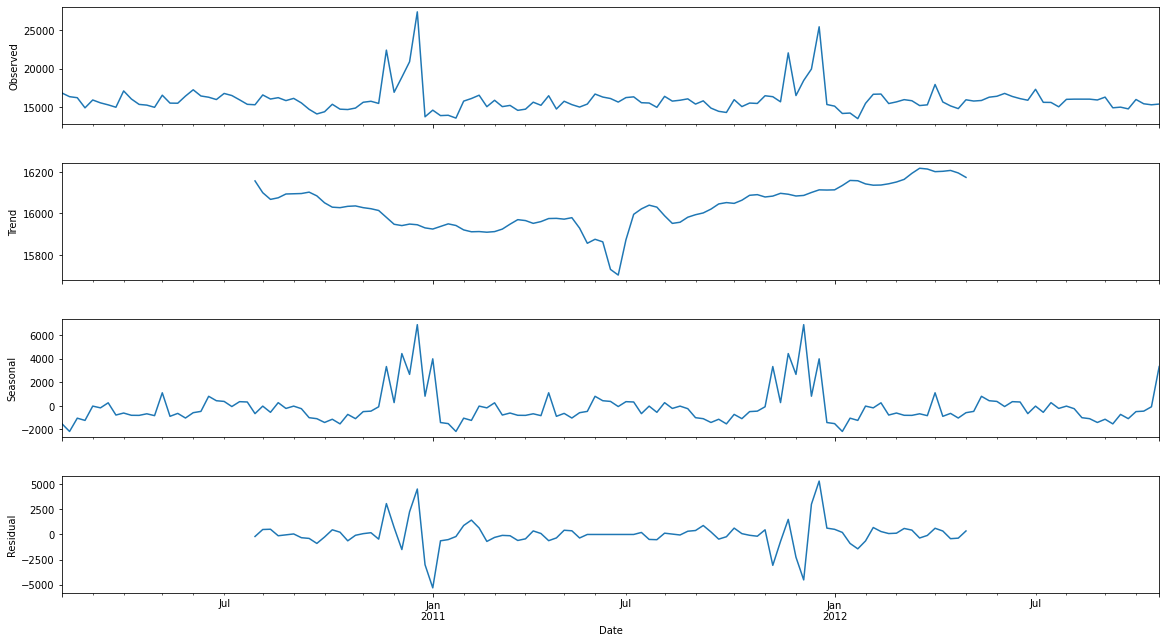

In [0]:
# import warnings
from datetime import datetime
# import itertools
import statsmodels.api as sm

df_pandas_2= df_pandas.copy()
df_pandas_2 = df_pandas_2.groupby('Date').Weekly_Sales.mean().reset_index()
df_pandas_2['Date'] = pd.to_datetime(df_pandas_2['Date'])
df_pandas_2 = df_pandas_2.set_index('Date')
df_pandas_2.index = pd.to_datetime(df_pandas_2.index)

#plt.plot(df_pandas_2['Date'],df_pandas_2['Weekly_Sales'],kind='line')
decomposition = sm.tsa.seasonal_decompose(df_pandas_2['Weekly_Sales'], model='additive',freq=50)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [0]:
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer

df_final = df_final.withColumn("CPI",df_final.CPI.cast("double"))
df_final = df_final.withColumn("Unemployment",df_final.Unemployment.cast("double"))
df_final = df_final.withColumn("MarkDown1",df_final.Unemployment.cast("double"))
df_final = df_final.withColumn("MarkDown2",df_final.Unemployment.cast("double"))
df_final = df_final.withColumn("MarkDown3",df_final.Unemployment.cast("double"))
df_final = df_final.withColumn("MarkDown4",df_final.Unemployment.cast("double"))
df_final = df_final.withColumn("MarkDown5",df_final.Unemployment.cast("double"))
df_final = df_final.withColumn("IsHoliday",F.when(df_final.IsHoliday=='false',F.lit(0)).otherwise(F.lit(1)))
indexer = StringIndexer(inputCol="Type", outputCol="Type_ind").fit(df_final)
df_final = indexer.transform(df_final)
cols_to_drop=["Type","Date"]
df_final1 = df_final.drop(*cols_to_drop)
df_final1.show()

+-----+---------+----+------------+------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+--------+
|Store|IsHoliday|Dept|Weekly_Sales|  Size|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|Type_ind|
+-----+---------+----+------------+------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+--------+
|    1|        0|   1|     24924.5|151315|      42.31|     2.572|    8.106|    8.106|    8.106|    8.106|    8.106|211.0963582|       8.106|     0.0|
|    1|        1|   1|    46039.49|151315|      38.51|     2.548|    8.106|    8.106|    8.106|    8.106|    8.106|211.2421698|       8.106|     0.0|
|    1|        0|   1|    41595.55|151315|      39.93|     2.514|    8.106|    8.106|    8.106|    8.106|    8.106|211.2891429|       8.106|     0.0|
|    1|        0|   1|    19403.54|151315|      46.63|     2.561|    8.106|    8.106|    8.106|    8

In [0]:
df_final1= df_final1.select(['Weekly_sales','Store','IsHoliday','Dept','Size','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment','Type_ind'])

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np 

values = df_final1.collect() 

scaler = StandardScaler()
scaled = scaler.fit_transform(values)

x= scaled[:][:-48]
y= scaled[:,0][48:]


In [0]:
from sklearn.model_selection import train_test_split

# split into train and test sets
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.20, random_state=42, shuffle = False)

# Create overlapping windows of lagged values for training and testing datasets
timesteps = 12
train_generator = TimeseriesGenerator(trainX, trainY, length=timesteps, sampling_rate=1, batch_size=timesteps)
test_generator = TimeseriesGenerator(testX, testY, length=timesteps, sampling_rate=1, batch_size=timesteps)

In [0]:
import tensorflow 
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.layers import LSTM

In [0]:
from tensorflow.keras import backend
import numpy as np
units = 128
num_epoch = 5
learning_rate = 0.001

model = Sequential()
model.add(LSTM(units, input_shape=(12, 15)))
model.add(LeakyReLU(alpha=0.5)) 
model.add(Dropout(0.1))
model.add(Dense(1))

adam = Adam(lr=learning_rate)

model.compile(loss='mse', optimizer=adam, metrics=['mae'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



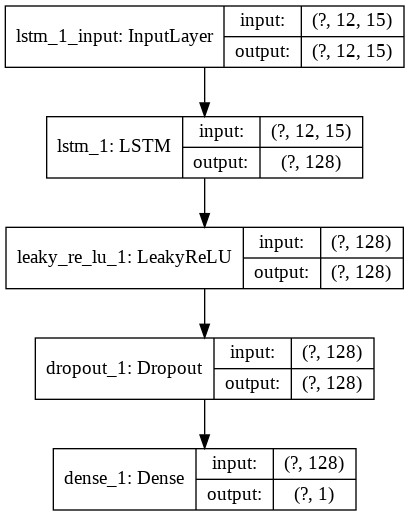

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

In [0]:
model.fit_generator(train_generator, epochs=10).history

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





28101/28101 [==============================] - 820s 29ms/step - loss: 0.4457 - mean_absolute_error: 0.3647
Epoch 2/10
28101/28101 [==============================] - 814s 29ms/step - loss: 0.3952 - mean_absolute_error: 0.3340
Epoch 3/10
28101/28101 [==============================] - 817s 29ms/step - loss: 0.3686 - mean_absolute_error: 0.3191
Epoch 4/10
28101/28101 [==============================] - 827s 29ms/step - loss: 0.3516 - mean_absolute_error: 0.3101
Epoch 5/10
28101/28101 [==============================] - 808s 29ms/step - loss: 0.3428 - mean_absolute_error: 0.3037
Epoch 6/10
28101/28101 [==============================] - 813s 29ms/step - loss: 0.3280 - mean_absolute_error: 0.2970
Epoch 7/10
28101/28101 [==============================] - 814s 29ms/step - loss: 0.3200 - mean_absolute_error: 0.2930
Epoch 8/10
28101/28101 [==============================] - 826s 29ms/step

{'loss': [0.4457280868373916,
  0.3952530698961758,
  0.36865275060094643,
  0.35160706224414934,
  0.3428256751837356,
  0.32802172868232765,
  0.3199730923799202,
  0.3103518630908583,
  0.3018307272234435,
  0.295438748129842],
 'mean_absolute_error': [0.36472748973487373,
  0.334051044862753,
  0.31909615135555586,
  0.31006386960538296,
  0.30374550498791447,
  0.2970005253555989,
  0.2930054192633593,
  0.287442539957936,
  0.2829588586204106,
  0.280217656191876]}

In [0]:
# Make predictions

import numpy as np

yhat_train_temp = model.predict_generator(train_generator)
yhat_test_temp = model.predict_generator(test_generator)

n_lead = 1
yhat_train = yhat_train_temp[:, n_lead-1]
yhat_test = yhat_test_temp[:, n_lead-1]

# training results
yhat_train_plot = np.empty(shape=[y.shape[0],])
yhat_train_plot[:] = np.nan
yhat_train.shape = yhat_train.shape[0]
yhat_train_plot.shape = yhat_train_plot.shape[0]
yhat_train_plot[timesteps:len(yhat_train)+timesteps] = yhat_train
  
#test results
yhat_test_plot = np.empty(shape=[y.shape[0],])
yhat_test_plot[:] = np.nan
yhat_test.shape = yhat_test.shape[0]
yhat_test_plot.shape = yhat_test_plot.shape[0]
yhat_test_plot[len(yhat_train)+(timesteps*2):len(y)] = yhat_test

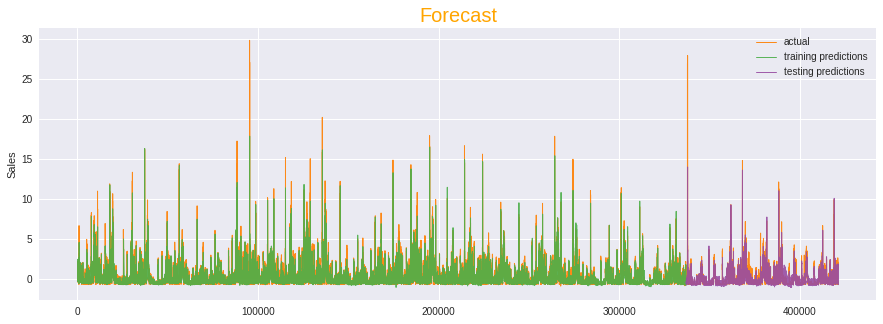

In [0]:
from matplotlib import pyplot

fig = pyplot.figure()
pyplot.style.use('seaborn')
palette = pyplot.get_cmap('Set1')
pyplot.plot(y, marker='', color=palette(4), linewidth=1, alpha=0.9, label='actual')
pyplot.plot(yhat_train_plot, marker='', color=palette(2), linewidth=1, alpha=0.9, label='training predictions')
pyplot.plot(yhat_test_plot, marker='', color=palette(3), linewidth=1, alpha=0.9, label='testing predictions')

pyplot.title('Forecast', loc='center', fontsize=20, fontweight=5, color='orange')
pyplot.ylabel('Sales')
pyplot.legend()
fig.set_size_inches(w=15,h=5)
pyplot.close()

display(fig)